In [1]:
import pandas as pd

In [22]:
df = pd.read_feather("100k_kindle_reviews_lemmatized_with_summary.feather")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   overall                100000 non-null  int64  
 1   verified               100000 non-null  bool   
 2   reviewTime             100000 non-null  object 
 3   reviewerID             100000 non-null  object 
 4   asin                   100000 non-null  object 
 5   style                  100000 non-null  object 
 6   reviewerName           100000 non-null  object 
 7   reviewText             100000 non-null  object 
 8   summary                100000 non-null  object 
 9   unixReviewTime         100000 non-null  int64  
 10  vote                   100000 non-null  int32  
 11  image                  70 non-null      object 
 12  lemmatized_reviewText  100000 non-null  object 
 13  ADV_review             80797 non-null   float64
 14  VERB_review            91419 non-null

In [24]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,PUNCT_summary,VERB_summary,DET_summary,NUM_summary,CCONJ_summary,SCONJ_summary,INTJ_summary,SPACE_summary,SYM_summary,X_summary
0,1,True,"12 27, 2014",A3JRP9RI3ZE6VK,B00JQDHIES,{'Format:': ' Kindle Edition'},e-BOOK,Truly hate it when I make a bad call on a book...,Juvenile,1419638400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,False,"06 25, 2016",A3IZWB0YUZXZZ6,B01H124NQQ,{'Format:': ' Kindle Edition'},Kathryn childs,Only 4% of this book is the discretion it isn'...,Not worth your time,1466812800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,True,"05 13, 2013",A82LP6E48UFM5,B00C2E9EK4,{'Format:': ' Kindle Edition'},Amazon Customer,The quality of writing for this book is very p...,poor quality,1368403200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,True,"05 10, 2012",AMV9B31WKSLM7,B005RH2GNU,{'Format:': ' Kindle Edition'},Eclectic Reader,"The Outback is the vast, remote, arid area of ...",Outback is in AUSTRALIA!!!,1336608000,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,True,"09 4, 2013",AZ27B4OUL64TR,B00DC7PXLY,{'Format:': ' Kindle Edition'},Word Junkie,"Grace Burrowes lives within a few miles of me,...",Not as good as its progenitor,1378252800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
review_speech_count_columns = [col for col in df.columns if col.endswith('_review')]
df[review_speech_count_columns] = df[review_speech_count_columns].fillna(0)

summary_speech_count_columns = [col for col in df.columns if col.endswith('_summary') and col != 'lemmatized_summary']
df[summary_speech_count_columns] = df[summary_speech_count_columns].fillna(0)

In [78]:
summary_speech_count_columns

['ADV_summary',
 'PART_summary',
 'ADJ_summary',
 'PRON_summary',
 'NOUN_summary',
 'AUX_summary',
 'ADP_summary',
 'PROPN_summary',
 'PUNCT_summary',
 'VERB_summary',
 'DET_summary',
 'NUM_summary',
 'CCONJ_summary',
 'SCONJ_summary',
 'INTJ_summary',
 'SPACE_summary',
 'SYM_summary',
 'X_summary']

In [27]:
# if image is non null return 1 else 0
df['image'] = df['image'].notnull().astype('int')

replace null with empty string

In [28]:
# in review text replace null values with empty string
df['reviewText'] = df['reviewText'].fillna('')
df['summary'] = df['summary'].fillna('')

convert verfied to dummy

In [29]:
# convert verified to int 1 if true 0 if false
df['verified'] = df['verified'].astype('int')

In [30]:
df = df.drop(columns=['style'])

dropped reviewtime, already have unix representation

In [31]:
# drop the reviewTime column
df = df.drop(columns='reviewTime')

creating review length column

In [32]:
# create a new column called reviewLength
df['reviewLength'] = df['reviewText'].apply(lambda x: 0 if isinstance(x, float) else len(x))

creating summary length column

In [33]:
# create a new column called summaryLength (There were some NaN values in summary, which was forcing the type to be float64.  This ensures everything is an int).
df['summaryLength'] = df['summary'].apply(lambda x: 0 if isinstance(x, float) else len(x))

asin is the amazon product id. removing this and the reviewer info

In [34]:
# removing asin, reviewerID, reviewerName
df = df.drop(columns=['asin', 'reviewerID', 'reviewerName'])

labeling categorical variables

In [35]:
# labeling ['verified', 'image'] as categorical
df[['overall', 'verified', 'image']] = df[['overall', 'verified', 'image']].astype('category')

reviewing data

In [60]:
# based off code from https://satish1v.medium.com/sentiment-analysis-and-nlp-dictionary-based-daf01781019e
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('opinion_lexicon') #Download Opinion Dictionary
positive_wds = set(opinion_lexicon.positive())
negative_wds = set(opinion_lexicon.negative())
nltk.download('punkt')


def score_review(review):
    sentiment_scores = []
    sents = sent_tokenize(review)
    for sent in sents:
        wds = word_tokenize(sent)
        sent_scores = score_sent(wds)
        sentiment_scores.append(sent_scores)
    return sum(sentiment_scores) / (len(sentiment_scores) or 1)

def score_sent(sent):
    """Returns a score btw -1 and 1"""
    sent = [e.lower() for e in sent if e.isalnum()]
    total = len(sent)
    pos = len([e for e in sent if e in positive_wds])
    neg = len([e for e in sent if e in negative_wds])
    if total > 0:
        return (pos - neg) / total
    else:
        return 0

df["reviewText_sentiment_score"] = df["reviewText"].apply(score_review)


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/andy/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:

df["summary_sentiment_score"] = df["summary"].apply(score_review)

In [70]:
df[['reviewText_sentiment_score', 'summary_sentiment_score']]

,reviewText_sentiment_score,summary_sentiment_score
0,-0.071429,0.000000
1,0.033333,0.250000
2,0.040476,-0.500000
3,0.028571,0.000000
4,0.055592,0.166667
...,...,...
99995,-0.013094,0.000000
99996,0.133333,0.333333
99997,0.192617,0.090909
99998,-0.006593,0.200000


Number of training samples: 75000
Micro-averaged F1 score on test set: 0.307
Accuracy of model: 0.3068


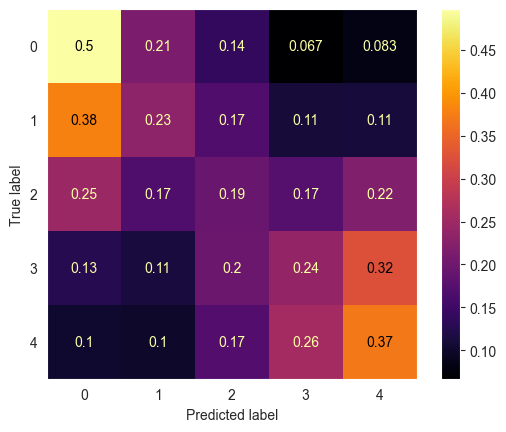

In [85]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 

from sklearn.ensemble import  RandomForestClassifier

pipeline = Pipeline(steps=[
    ("clf", RandomForestClassifier())
])

best_params = {

}

classifier = pipeline.set_params(**best_params)

# The space is important, otherwise this accidentally creates joined words.
X, y = df[['reviewText_sentiment_score', 'summary_sentiment_score']], df['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55)

print("Number of training samples:", len(X_train))

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Micro-averaged F1 score on test set: %0.3f"% f1_score(y_test, y_pred, average="micro"))

accuracy = classifier.score(X_test, y_test)
print(f"Accuracy of model: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='inferno')
plt.grid(None)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pipeline = Pipeline(steps=[
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", SGDClassifier())
])

best_params = {
    'vect__ngram_range': (1, 3),
    'vect__stop_words': None,
    'vect__strip_accents': None,
    'tfidf__norm': 'l2',
    'tfidf__sublinear_tf': True,
    'tfidf__use_idf': True,
    'clf__alpha': 1e-05,
    'clf__loss': 'log_loss',
    'clf__penalty': 'elasticnet',
}

classifier = pipeline.set_params(**best_params)

# The space is important, otherwise this accidentally creates joined words.
X, y = df['reviewText'] + " " + df['summary'],  df['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55)

print("Number of training samples:", len(X_train))

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Micro-averaged F1 score on test set: %0.3f"% f1_score(y_test, y_pred, average="micro"))

accuracy = classifier.score(X_test, y_test)
print(f"Accuracy of model: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='inferno')

In [73]:
y_train

33364    2
49406    3
41740    3
68165    4
42153    3
        ..
10213    1
16253    1
82888    5
28967    2
4762     1
Name: overall, Length: 75000, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

NameError: name 'plt' is not defined

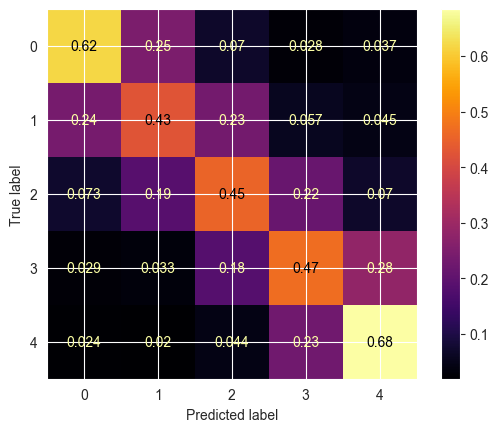

In [38]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='inferno')
plt.grid(None)
plt.show()